In [1]:
from becquerel import Spectrum
import numpy as np
import matplotlib.pyplot as plt
import becquerel as bq
import scipy.integrate as integrate
import math as m
import importlib
import os
import sys
sys.path.append("../")
import PF
import ROI
import analysis_methods as am

C:\Users\Daniel\Anaconda3\lib\site-packages\html5lib\_trie\_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [2]:
importlib.reload(PF)
importlib.reload(ROI)
importlib.reload(am)

<module 'analysis_methods' from '..\\analysis_methods.py'>

In [3]:
def f_near(a,a0):
    idx = np.abs(a-a0).argmin()
    return idx

def plot_peak_region(roi, spectrum, sourcen_energies, key):
    target_peaks = roi.target_peaks
    spec = spectrum
    counts = spec.counts_vals
    energies = spec.bin_centers_kev
    idx = f_near(energies,key) 
    roi_low = idx - 50
    roi_high = idx + 50

    plot_counts = counts[roi_low:roi_high]
    plot_energies = energies[roi_low:roi_high]
        
    roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(roi.roi_pars["%s" %key])
    rlow = roi_low_bins[0][0]
    rhi = roi_high_bins[0][-1]
    plot_counts = counts[rlow:rhi]
    plot_energies = energies[rlow:rhi]

    rlow = roi_low_bins[0][0]
    rhi = roi_low_bins[0][-1]
    low_counts = counts[rlow:rhi]
    low_energies = energies[rlow:rhi]

    rlow = roi_high_bins[0][0]
    rhi = roi_high_bins[0][-1]
    high_counts = counts[rlow:rhi]
    high_energies = energies[rlow:rhi]

    rlow = roi_peak_bins[0][0]
    rhi = roi_peak_bins[0][-1]
    peak_counts = counts[rlow:rhi]
    peak_energies = energies[rlow:rhi]

    fig,ax = plt.subplots()
    ax.plot(plot_energies,plot_counts)
    ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
    ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
    ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
    ax.set_yscale('log')
    plt.title("%s Peak" %key)

def efficiency(roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer):
    eff = []
    eff_uncer = []
    for count,A,br,sigma_c,sigma_A in zip (roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer):
        eff.append(count/spec.livetime/A/br)
        eff_uncer.append(m.sqrt((sigma_c/A)**2+(count*sigma_A/A**2)**2)/br/spec.livetime)
    return eff, eff_uncer

In [4]:
def plot_spec(spectrum, xmode='channel'):
    if xmode == 'channel':
        facecolor = 'green'
    else:
        facecolor = 'blue'
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot('k-', lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == 'channel':
        plt.xlim(0, spectrum.bin_edges_raw.max())
        plt.title('Uncalibrated spectrum')
    else:
        plt.xlim(0, spectrum.energies_kev[-1])
        plt.title('Calibrated spectrum')
    plt.yscale('log')
    plt.ylim(2e-1)
    plt.tight_layout()
def plot_calibrator(cal):
    cal.peakfinder.spectrum.apply_calibration(cal.cal)
    print('fit gain:', cal.gain, 'keV/channel')
    print('fit channels:', cal.fit_channels)

    plt.figure()
    plt.title('Peaks used in fit')
    cal.plot()
    plt.tight_layout()
    #plt.savefig('peaks used in fit.png',dpi = 200)

    plot_spec(cal.peakfinder.spectrum, xmode='channel')
    for x, erg in zip(cal.fit_channels, cal.fit_energies):
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-10:chan+10].max() * 1.5
        plt.plot([x, x], [1e-1, y], 'r-', alpha=0.5)
        plt.text(x, y, '{:.1f} keV'.format(erg))
    #plt.savefig('Uncal spec.png',dpi = 200)


    plot_spec(cal.peakfinder.spectrum, xmode='energy')
    for erg in cal.fit_energies:
        x = int(erg / cal.gain)
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-15:chan+15].max() * 1.5
        plt.plot([erg, erg], [1e-1, y], 'r-', alpha=0.5)
        plt.text(erg, y, '{:.1f} keV'.format(erg))
    #plt.savefig('cal spec.png',dpi=200)

In [5]:
path = r'C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis'
spec = path + r'\NAA_eff_calibration_long.Spe'
bg = path + r'\background-long.Spe'
#ecal = path + r'\E-calibration-Eu152.Spe'
#this set of eff data was already energy calibrated

spec = bq.Spectrum.from_file(spec)
bg = bq.Spectrum.from_file(bg)
#ecal = bq.Spectrum.from_file(ecal)

counts = spec.counts_vals
energies = spec.bin_centers_kev

SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis\NAA_eff_calibration_long.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis\background-long.Spe


In [6]:
#Find Lu-176, La-138, K-40
source_isotopes = np.array(['Lu_176_1','Lu_176_2','Lu_176_3',
                          'La_138_1','La_138_2',
                           'K-40']); #get counts under the peak subtrack the background
source_energies = np.array([88.34,
                            201.83,306.78,
                           788.742,1435.795,
                           1460.83]);
source_activities = np.array([16.259,
                              16.259,16.259,
                             11.646,11.646,
                              424.65]);#Bq/L, update this with correct mass, by .0098 g
branching_ratio = np.array([0.11,
                            0.86,0.94,
                           0.34,0.66,
                           0.11]);
activities_uncer = np.array([1.6259,
                             1.6259,1.6259,
                            0.02329,0.02329,
                            0.8493])
'''The real source energies:
Lu-176: 88.34, 201.83, 306.78
La-138: 788.742,1435.795
K-40: 1460.83'''
source_activities = source_activities * .0098 #accounting for NAA sample weight
activities_uncer = activities_uncer * .0098
print(source_activities)
print(type(source_energies[0]))
type(88.34)

[0.1593382 0.1593382 0.1593382 0.1141308 0.1141308 4.16157  ]
<class 'numpy.float64'>


float

In [7]:
roi = ROI.ROI(spec, bg, source_energies, 0)#0 subtracts bg after ROI is applied, (diff cal can work)
#roi_counts, roi_unc = roi.get_counts()
#print(roi_counts)
#print(roi_unc)

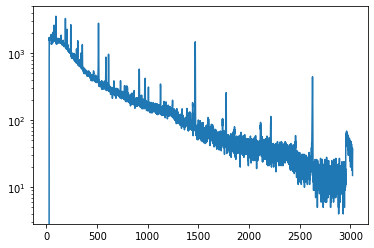

In [8]:
plt.plot(energies,counts)
plt.yscale('log')

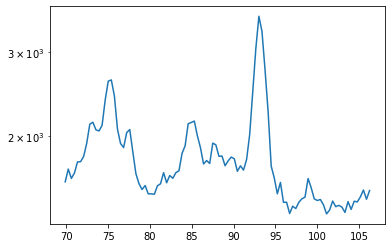

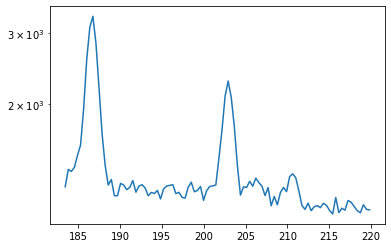

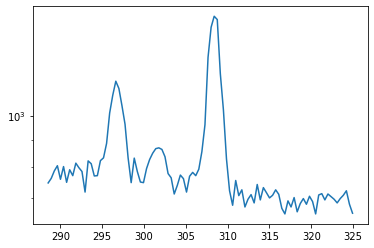

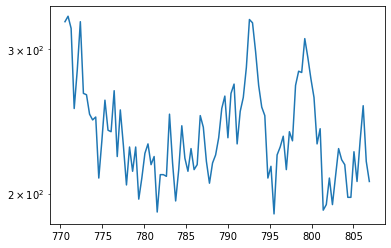

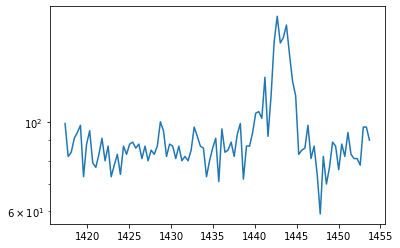

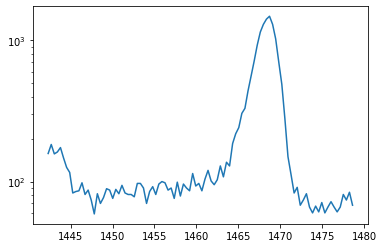

In [9]:
for i in source_energies:
    index0 = f_near(energies, i)
    plt.plot(energies[index0-50:index0+50], counts[index0-50:index0+50])
    plt.yscale('log')
    plt.show()

In [10]:
roi.set_sideband(float(source_energies[0]), 3,[[-2, -1], [-.5, .5], [1, 2]])
roi.find_peak_energies()
print(roi.roi_pars)

{'88.34': [88.0, 3, [[-2, -1], [-0.5, 0.5], [1, 2]], [[-2, -1], [-0.5, 0.5], [1, 2]]], '201.83': [203.0, 5, [[-2, -1], [-0.5, 0.5], [1, 2]], [[-2, -1], [-0.5, 0.5], [1, 2]]], '306.78': [308.0, 5, [[-2, -1], [-0.5, 0.5], [1, 2]], [[-2, -1], [-0.5, 0.5], [1, 2]]], '788.742': [791.0, 5, [[-2, -1], [-0.5, 0.5], [1, 2]], [[-2, -1], [-0.5, 0.5], [1, 2]]], '1435.795': [1438.0, 5, [[-2, -1], [-0.5, 0.5], [1, 2]], [[-2, -1], [-0.5, 0.5], [1, 2]]], '1460.83': [1463.0, 5, [[-2, -1], [-0.5, 0.5], [1, 2]], [[-2, -1], [-0.5, 0.5], [1, 2]]]}


In [77]:
roi.set_sideband(float(source_energies[0]), 3,[[-2.5, -1.3], [-.6, .5], [.55, 1.4]])
roi.set_sideband(float(source_energies[1]), 5, [[-1.8, -.5], [-.4, .5], [.5, 1.5]])
roi.set_sideband(float(source_energies[2]), 5, [[-5, -3], [-.5, .7], [.9, 3]])
roi.set_sideband(float(source_energies[3]), 5, [[-2, -.8], [-.4, 1.1], [1.9, 3]])
roi.set_sideband(float(source_energies[4]), 10, [[-1.5, -.5], [-.1, .9], [1, 2]])
roi.set_sideband(float(source_energies[5]), 10, [[-1.8, -.4], [-.3, 1.1], [1.5, 3]])

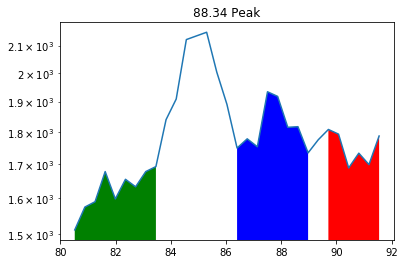

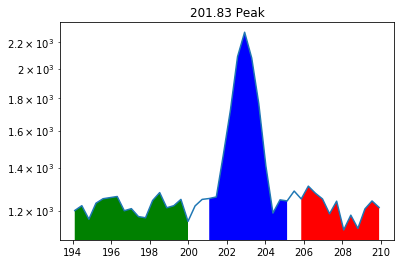

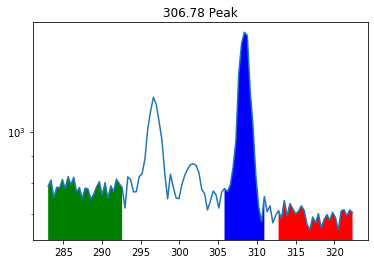

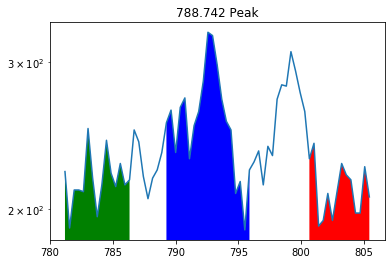

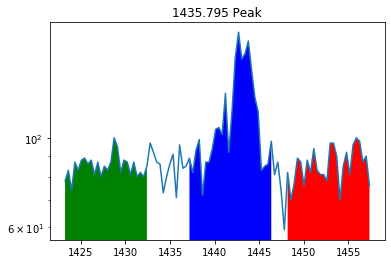

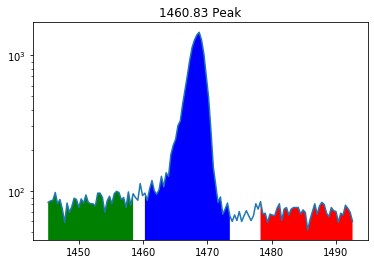

In [78]:
plot_peak_region(roi, spec, source_energies, float(source_energies[0]))
plot_peak_region(roi, spec, source_energies, float(source_energies[1]))
plot_peak_region(roi, spec, source_energies, float(source_energies[2]))
plot_peak_region(roi, spec, source_energies, float(source_energies[3]))
plot_peak_region(roi, spec, source_energies, float(source_energies[4]))
plot_peak_region(roi, spec, source_energies, float(source_energies[5]))

In [25]:
roi.set_sideband(float(source_energies[0]), 5,[[-1.2, -.8], [-.2, .3], [.6, 1.2]], 1)
roi.set_sideband(float(source_energies[1]), 5, [[-1.8, -.5], [-.4, .4], [.5, 1.5]],1)
roi.set_sideband(float(source_energies[2]), 5, [[-5, -3], [-.4, .6], [.8, 3]],1)
roi.set_sideband(float(source_energies[3]), 5, [[-2, -.8], [-.4, .6], [1.8, 3]],1)
roi.set_sideband(float(source_energies[4]), 5, [[-2.8, -.8], [-.5, .6], [1, 3]],1)
roi.set_sideband(float(source_energies[5]), 5, [[-4, -2], [-1, .8], [1, 3]],1)

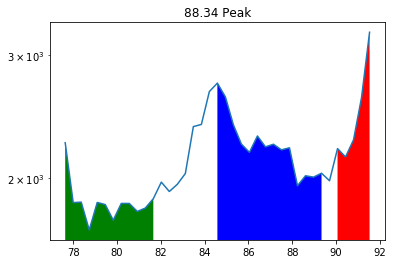

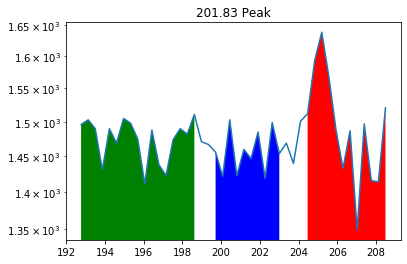

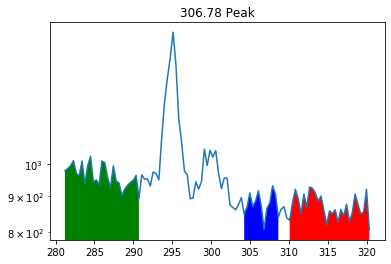

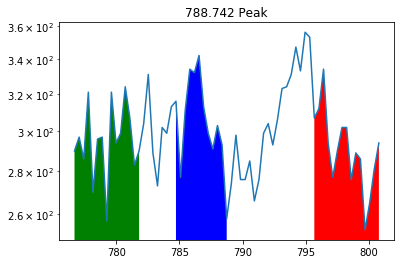

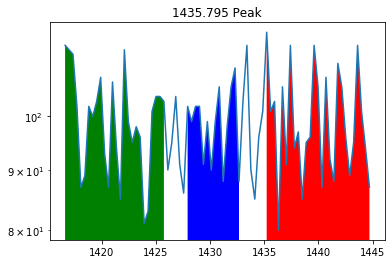

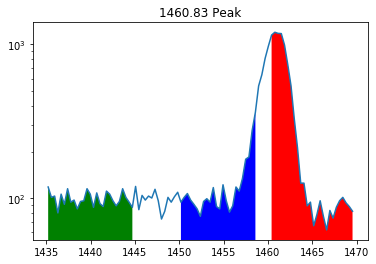

In [26]:
plot_peak_region(roi, bg, source_energies, float(source_energies[0]))
plot_peak_region(roi, bg, source_energies, float(source_energies[1]))
plot_peak_region(roi, bg, source_energies, float(source_energies[2]))
plot_peak_region(roi, bg, source_energies, float(source_energies[3]))
plot_peak_region(roi, bg, source_energies, float(source_energies[4]))
plot_peak_region(roi, bg, source_energies, float(source_energies[5]))

In [16]:
roi_counts=[]
roi_unc =[]
roi_counts, roi_unc = roi.get_counts()

background spec sidebands 30169.716259416713
bg peak counts 31611.901486582352
signal bg 39751.0
signal peak 94803.0
background spec sidebands 20073.058260924456
bg peak counts 13329.095183231364
signal bg 17649.5
signal peak 16511.0
background spec sidebands 23068.156592986517
bg peak counts 10263.203617866013
signal bg 20655.0
signal peak 13642.0
background spec sidebands 4399.164125910556
bg peak counts 3448.9011096472277
signal bg 3239.0
signal peak 3264.0
background spec sidebands 2305.3181101326204
bg peak counts 1244.3272161385132
signal bg 2425.0
signal peak 1249.9999999999998
background spec sidebands 2175.5305157432645
bg peak counts 10824.103850961272
signal bg 5372.500000000001
signal peak 4041.9999999999995


In [17]:
print(roi_counts)
print(roi_unc)

[53609.81477283436, 5605.463077693092, 5791.952975120505, 975.2630162633286, -114.00910600589305, -9979.073335218009]
[491.8974945754301, 219.8009675440559, 214.36666707899803, 101.03898057166784, 70.04123181754095, 109.95731226860295]


In [18]:
eff,eff_uncer = efficiency(roi_counts,source_activities,branching_ratio,roi_unc,activities_uncer)
print(eff,eff_uncer)

[2.9959552607558897, 0.04006791531122099, 0.03787746239435782, 0.02461747954124407, -0.001482505632523226, -0.021352264166467665] [0.3008540304417681, 0.00430381910367311, 0.004038850034583424, 0.0025508897085214457, 0.0009107787479397819, 0.0002391203164846361]


In [19]:
plot_eff = am.Efficiency(source_energies,eff,eff_uncer)

plot_eff.mutate()
plot_eff.fitting()
plot_eff.plotter()

..\analysis_methods.py:48: RuntimeWarning: invalid value encountered in log
  self.y.append(np.log(i))


LinAlgError: SVD did not converge in Linear Least Squares